<a href="https://colab.research.google.com/github/mphani/ts_prophet/blob/works/actual_as_prophet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from tabulate import tabulate

from prophet import Prophet
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from prophet.plot import plot_plotly, plot_components_plotly

from prophet.plot import add_changepoints_to_plot, plot_cross_validation_metric


In [2]:
G_FILENAME = "sample_data/24122023_aerospike_stats.csv"

In [3]:
original_df = pd.read_csv(G_FILENAME)
original_df.head()

,cluster_name,instance,ns,service,metric_name,sub_query_name,prom_query,utc_date_time,metric_value
0,numa,192.168.200.239:9145,ssd,192.168.201.239:3000,aerospike_namespace_client_read_success,rate_query,rate(aerospike_namespace_client_read_success[1m]),1703010600,2882.088889
1,numa,192.168.200.239:9145,ssd,192.168.201.239:3000,aerospike_namespace_client_read_success,rate_query,rate(aerospike_namespace_client_read_success[1m]),1703010660,3006.044444
2,numa,192.168.200.239:9145,ssd,192.168.201.239:3000,aerospike_namespace_client_read_success,rate_query,rate(aerospike_namespace_client_read_success[1m]),1703010720,2960.888889
3,numa,192.168.200.239:9145,ssd,192.168.201.239:3000,aerospike_namespace_client_read_success,rate_query,rate(aerospike_namespace_client_read_success[1m]),1703010780,3010.822222
4,numa,192.168.200.239:9145,ssd,192.168.201.239:3000,aerospike_namespace_client_read_success,rate_query,rate(aerospike_namespace_client_read_success[1m]),1703010840,2992.222222


In [4]:
original_df["date_from_utc"] = pd.to_datetime(original_df.utc_date_time , unit='s')
original_df["full_date"] = original_df["date_from_utc"].dt.date
original_df["year"] = original_df["date_from_utc"].dt.year
original_df["month"] = original_df["date_from_utc"].dt.month
original_df["day"] = original_df["date_from_utc"].dt.day
original_df["hour"] = original_df["date_from_utc"].dt.hour
original_df["minute"] = original_df["date_from_utc"].dt.minute
original_df["second"] = original_df["date_from_utc"].dt.second

In [5]:
print( original_df.shape)

(419622, 17)


In [6]:
read_df= original_df[ original_df.metric_name=="aerospike_namespace_client_read_success"]
read_df= read_df[ read_df.sub_query_name=="simple_query"]
# pick up only ssd namespace
read_df= read_df[ read_df.ns=="ssd" ]
# read_df= read_df[ (read_df.ns=="ssd") & (read_df.service=="192.168.201.241:3000")]
read_df.shape

(69946, 17)

In [7]:
read_df= read_df[ read_df.service=="192.168.201.241:3000"]
read_df.shape

(23315, 17)

In [58]:
print(read_df["service"].unique())
print(read_df["ns"].unique())
print(read_df["cluster_name"].unique())
print(read_df["metric_name"].unique())
print((read_df["full_date"].unique()))

['192.168.201.241:3000']
['ssd']
['numa']
['aerospike_namespace_client_read_success']
[datetime.date(2023, 12, 16) datetime.date(2023, 12, 17)
 datetime.date(2023, 12, 13) datetime.date(2023, 12, 14)
 datetime.date(2023, 12, 10) datetime.date(2023, 12, 11)
 datetime.date(2023, 12, 12) datetime.date(2023, 12, 18)
 datetime.date(2023, 12, 20) datetime.date(2023, 12, 21)
 datetime.date(2023, 12, 22) datetime.date(2023, 12, 23)
 datetime.date(2023, 12, 24) datetime.date(2023, 12, 8)
 datetime.date(2023, 12, 9) datetime.date(2023, 12, 15)
 datetime.date(2023, 12, 19) datetime.date(2023, 12, 7)]


In [14]:
read_df_len = len(read_df)

train_size = int(read_df_len * 0.8)

# 80% as train and 20% as test
#
train_read_df = read_df[:train_size]
test_df = read_df.iloc[train_size:]

print( "len(read_df_len)   ==> ",len(read_df))
print( "len(train_read_df) ==> ", len(train_read_df) )
print( "len(test_df)       ==> ", len(test_df) )

len(read_df_len)   ==>  23315
len(train_read_df) ==>  18652
len(test_df)       ==>  4663


In [15]:
# read_df["full_date", "metric_value"].plot()
prophet_read_df = train_read_df[ ["date_from_utc", "metric_value"] ].copy()
prophet_read_df['date_from_utc'] = pd.to_datetime(prophet_read_df['date_from_utc'], format='%Y-%m-%d %H:%M:%S')

In [20]:
prophet_read_df.rename(columns={"date_from_utc": "ds", "metric_value": "y"}, inplace=True)
prophet_read_df=prophet_read_df.reset_index()
prophet_read_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18652 entries, 0 to 18651
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   level_0  18652 non-null  int64         
 1   index    18652 non-null  int64         
 2   ds       18652 non-null  datetime64[ns]
 3   y        18652 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(2)
memory usage: 583.0 KB


In [22]:
l_sort_column_names = ["ds"]
prophet_read_df.sort_values(by= l_sort_column_names, ascending = True)
print( "len(prophet_read_df) ==> ", len(prophet_read_df))

len(prophet_read_df) ==>  18652


In [23]:
# Removing duplicates in the original DataFrame
prophet_read_df.drop_duplicates(subset="ds", inplace=True)


In [ ]:
prophet_read_df.plot()

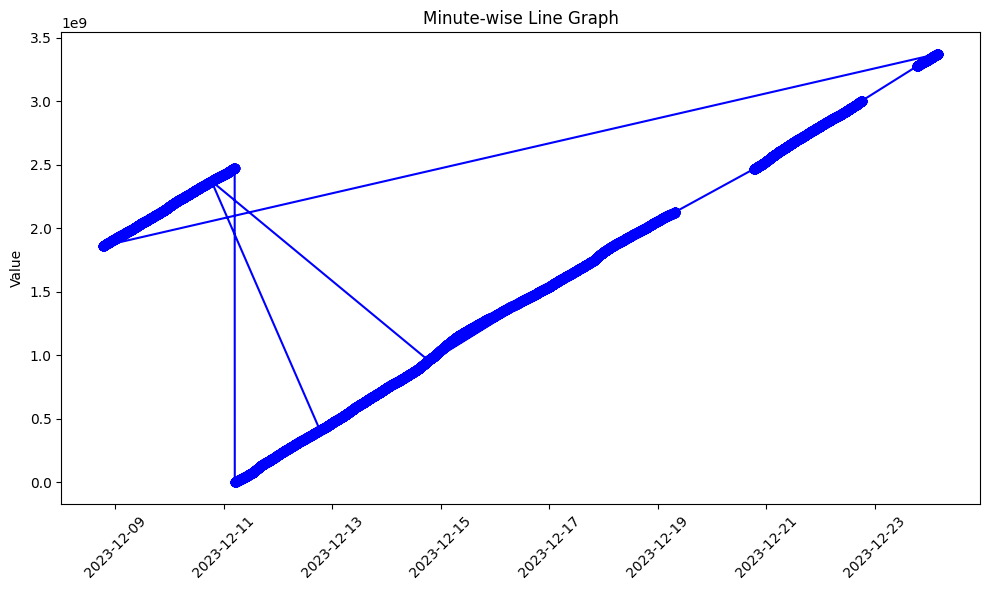

In [27]:

# Plotting a line graph
plt.figure(figsize=(10, 6))  # Set figure size as needed

plt.plot(prophet_read_df['ds'], prophet_read_df['y'], color='blue', marker='o', linestyle='-')

# plt.xlabel('Timestamp')
plt.ylabel('Value')
plt.title('Minute-wise Line Graph')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability if needed
plt.tight_layout()  # Adjusts plot to fit into the figure area
plt.show()

In [ ]:
# Plotting a line graph
plt.figure(figsize=(10, 6))  # Set figure size as needed

single_day_df = train_read_df [ train_read_df.day == 15 ]

single_day_df = single_day_df[ ["date_from_utc", "metric_value"] ].copy()
single_day_df.rename(columns={"date_from_utc": "ds", "metric_value": "y"}, inplace=True)
single_day_df.info()

# plt.plot(single_day_df['ds'], single_day_df['y'], color='green', marker='o', linestyle='--')
plt.bar (single_day_df['ds'], single_day_df['y'], )


plt.xlabel('Timestamp')
plt.ylabel('Value')
plt.title('Minute-wise Line Graph')
# plt.xticks(rotation=45)  # Rotate x-axis labels for better readability if needed
plt.tight_layout()  # Adjusts plot to fit into the figure area
plt.show()

In [28]:
m = Prophet()
# m= Prophet( interval_width=0.9, yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=True )
m.fit(prophet_read_df)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8xfmdy22/2r4c358m.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8xfmdy22/h4mr69r3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=3732', 'data', 'file=/tmp/tmp8xfmdy22/2r4c358m.json', 'init=/tmp/tmp8xfmdy22/h4mr69r3.json', 'output', 'file=/tmp/tmp8xfmdy22/prophet_modelbjotozx2/prophet_model-20231224085743.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:57:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:58:07 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [48]:
# 1440 = 24 * 60 minutes
# 4320 = 1440 * 3 days

#
future = m.make_future_dataframe(periods= 4320, freq="T", include_history=False)
future.tail()


,ds
4315,2023-12-27 04:02:00
4316,2023-12-27 04:03:00
4317,2023-12-27 04:04:00
4318,2023-12-27 04:05:00
4319,2023-12-27 04:06:00


In [53]:
train_read_df["date_from_utc"].max()
# train_read_df.info()

Timestamp('2023-12-24 04:06:00')

In [49]:
forecast = m.predict( future)
#
# only for anamoly
# forecast = m.predict( prophet_read_df)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()
forecast.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4320 entries, 0 to 4319
Data columns (total 19 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   ds                          4320 non-null   datetime64[ns]
 1   trend                       4320 non-null   float64       
 2   yhat_lower                  4320 non-null   float64       
 3   yhat_upper                  4320 non-null   float64       
 4   trend_lower                 4320 non-null   float64       
 5   trend_upper                 4320 non-null   float64       
 6   additive_terms              4320 non-null   float64       
 7   additive_terms_lower        4320 non-null   float64       
 8   additive_terms_upper        4320 non-null   float64       
 9   daily                       4320 non-null   float64       
 10  daily_lower                 4320 non-null   float64       
 11  daily_upper                 4320 non-null   float64     

<Axes: xlabel='ds'>

<Figure size 1000x600 with 0 Axes>

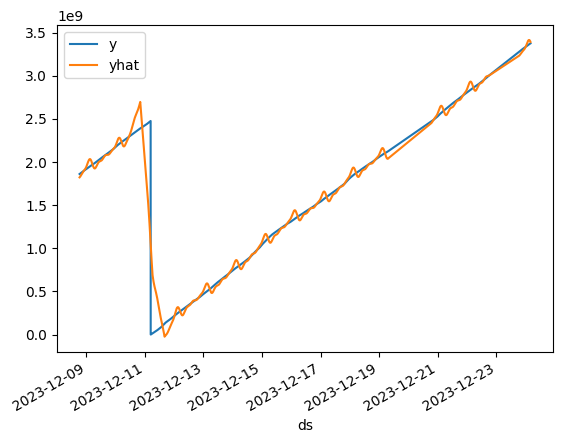

In [31]:

pd.concat( [prophet_read_df.set_index("ds")["y"],  forecast.set_index("ds")["yhat"]], axis=1).plot()

In [34]:
# merge original and forecasted
#
merged_df = pd.merge( prophet_read_df, forecast[["ds", "yhat","yhat_lower","yhat_upper"]], on="ds" )

In [35]:
merged_df.to_csv("prophet_forecasted.csv")

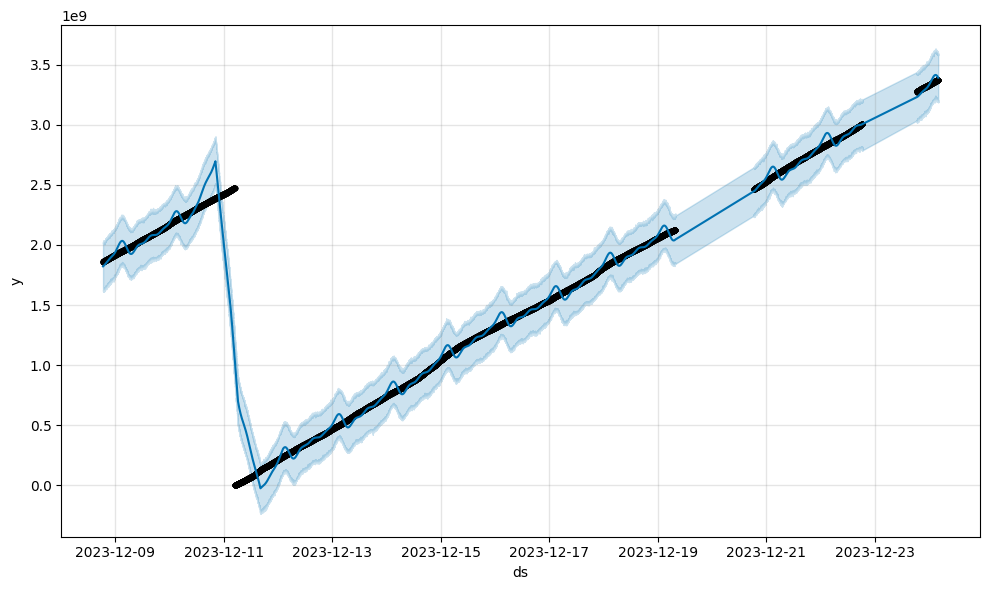

In [36]:
figure_1 = m.plot(forecast)


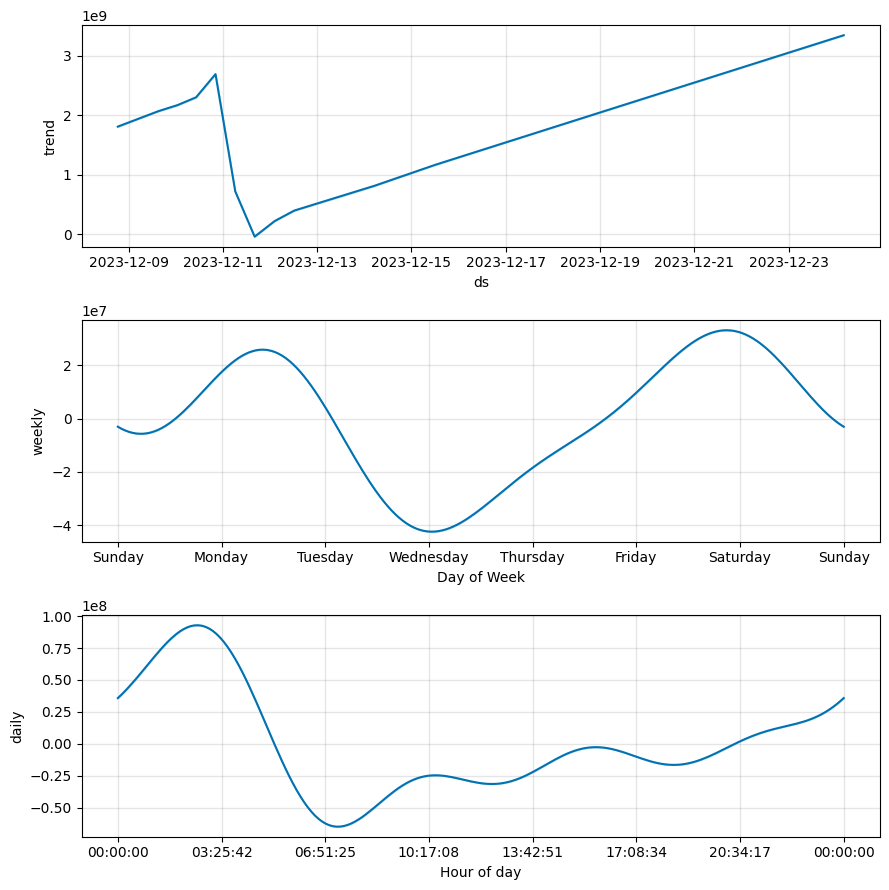

In [37]:
figure_2 = m.plot_components(forecast)

In [38]:
plot_plotly(m, forecast)

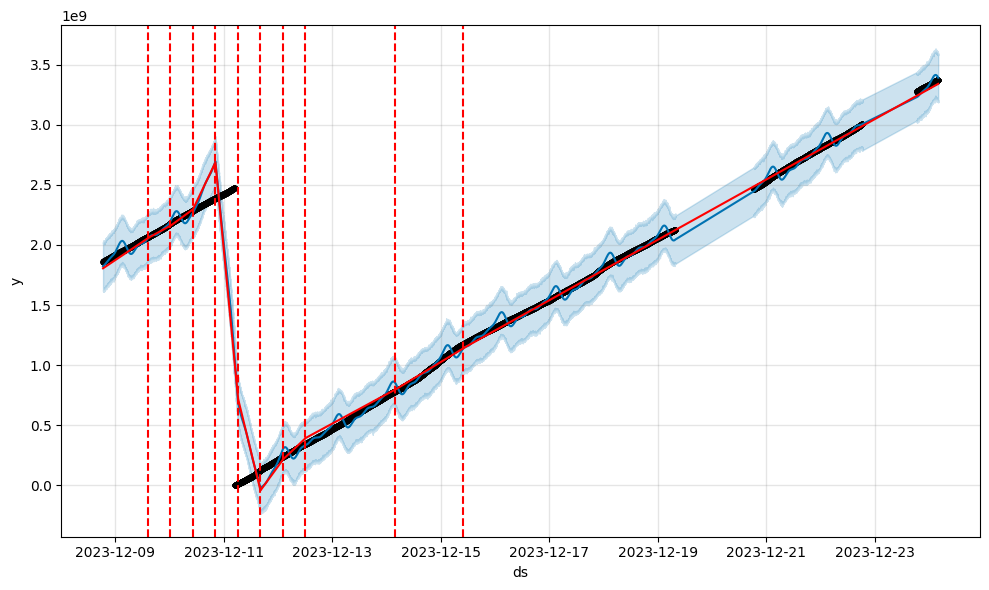

In [39]:
fig_change_points = add_changepoints_to_plot ( figure_1.gca(), m, forecast)
figure_1

In [40]:
# error and metrics
perf_mae = mean_absolute_error(merged_df['y'], merged_df['yhat'])
print ("mae ", perf_mae)
perf_mape = mean_absolute_percentage_error(merged_df['y'], merged_df['yhat'])
print("mape " , perf_mape )

mae  64086732.742013544
mape  2.526280476515569e+20


In [41]:
merged_df["anomaly"] = merged_df.apply(lambda rows: 1 if ((rows.y<rows.yhat_lower)|(rows.y>rows.yhat_upper)) else 0, axis = 1)

# Check the number of anomalies
merged_df["anomaly"].value_counts()

0    17628
1     1024
Name: anomaly, dtype: int64

In [ ]:
anomalies_df = merged_df[ merged_df["anomaly"]==1].sort_values(by='ds')
anomalies_df.head(100)

<Axes: xlabel='ds', ylabel='y'>

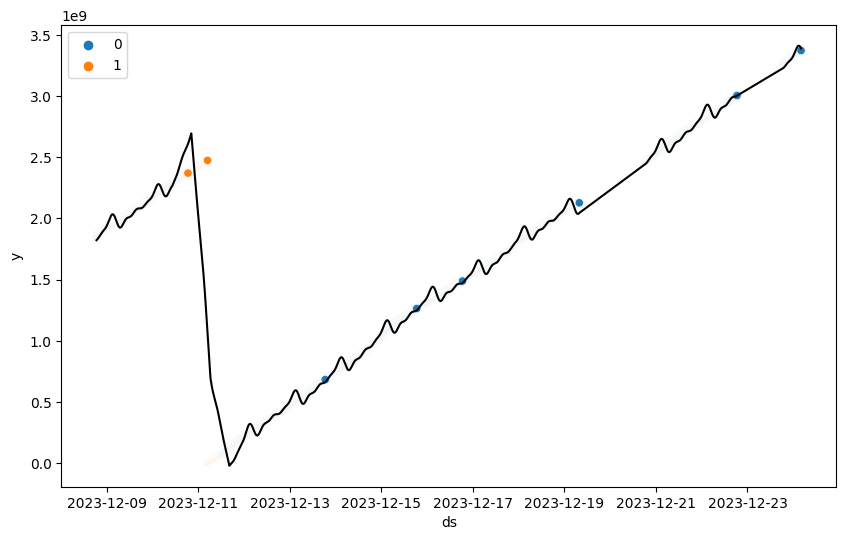

In [43]:
# Visualize the anomalies
plt.figure(figsize=(10, 6))
sns.scatterplot(x="ds", y="y", data=merged_df, hue="anomaly")
sns.lineplot(x="ds", y="yhat", data=merged_df, color="black")

In [44]:
# Calculate residuals (difference between actual and predicted values)
merged_df['residuals'] = merged_df['y'] - merged_df['yhat']

merged_df.info()

# single_merged_df =


<class 'pandas.core.frame.DataFrame'>
Int64Index: 18652 entries, 0 to 18651
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   level_0     18652 non-null  int64         
 1   index       18652 non-null  int64         
 2   ds          18652 non-null  datetime64[ns]
 3   y           18652 non-null  float64       
 4   yhat        18652 non-null  float64       
 5   yhat_lower  18652 non-null  float64       
 6   yhat_upper  18652 non-null  float64       
 7   anomaly     18652 non-null  int64         
 8   residuals   18652 non-null  float64       
dtypes: datetime64[ns](1), float64(5), int64(3)
memory usage: 1.4 MB


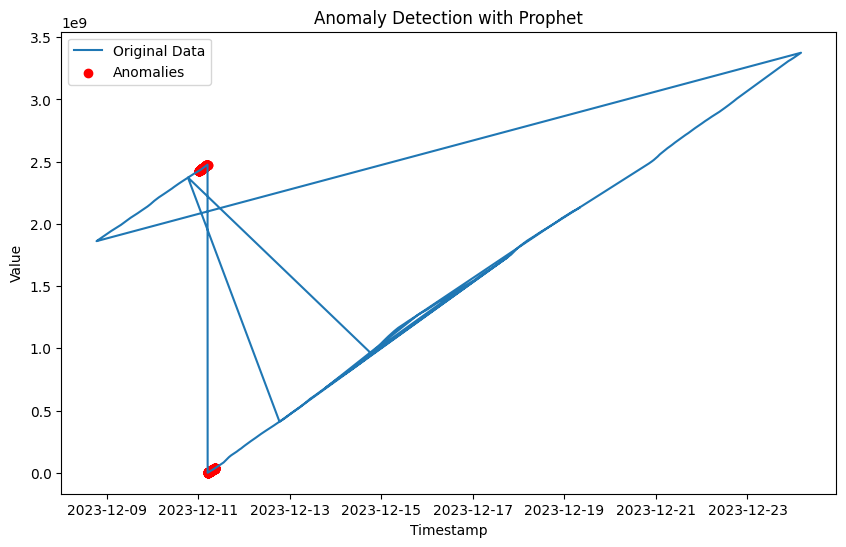

In [46]:
# Calculate mean and standard deviation of residuals
mean_residual = merged_df['residuals'].mean()
std_residual = merged_df['residuals'].std()

# Set a threshold for anomalies (e.g., 3 standard deviations)
threshold = 3 * std_residual

# Identify anomalies
anomalies = merged_df[np.abs(merged_df['residuals'] - mean_residual) > threshold]

# Plotting the data and anomalies
plt.figure(figsize=(10, 6))
plt.plot(merged_df['ds'], merged_df['y'], label='Original Data')
plt.scatter(anomalies['ds'], anomalies['y'], color='red', label='Anomalies')
plt.legend()
plt.xlabel('Timestamp')
plt.ylabel('Value')
plt.title('Anomaly Detection with Prophet')
plt.show()

In [ ]:
perf_cv = cross_validation(m, initial='6 days', period='2 days', horizon = '1 days')

In [ ]:
perf_cv_metrics = performance_metrics( perf_cv)
perf_cv_metrics.info()

perf_cv_metrics

In [ ]:
fig = plot_cross_validation_metric(perf_cv, metric='mape')